In [13]:
from pathlib import Path

DATA_DIR = "./data"
IMAGE_PATH = str(Path(DATA_DIR, "apple.png"))
OUTPUT_PATH = str(Path(DATA_DIR, "output.png"))
print(IMAGE_PATH)

data/apple.png


In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def convert_bgr2rgb(image_bgr):
    return cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)


def pil2cv(image_pil, convert_channel=True):
    image_np = np.array(image_pil, dtype=np.uint8)
    if convert_channel:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    return image_np


def show_image_from_ndarray(image_array, bgr2rgb=True):
    if (len(image_array.shape) < 3) or (image_array.shape[-1] == 1):
        plt.imshow(image_array)
        plt.axis("off")
    else:
        if bgr2rgb:
            plt.imshow(convert_bgr2rgb(image_array))
        else:
            plt.imshow(image_array)
        plt.axis("off")


In [15]:
import numpy as np
from scipy.fft import fft2, ifft2


def circshift(arr, shift):
    """
    Circular shift the elements of the input array along specified dimensions.
    Args:
        arr (np.ndarray): The input array.
        shift (tuple): Shift values for each dimension.

    Returns:
        np.ndarray: The circular shifted array.
    """
    return np.roll(arr, shift, axis=tuple(range(arr.ndim)))


def psf2otf(psf, out_size):
    """
    Convert a point spread function (PSF) to an optical transfer function (OTF).
    Args:
        psf (np.ndarray): The input PSF.
        out_size (tuple): The desired output shape.

    Returns:
        np.ndarray: The computed OTF.
    """
    psf_shape = psf.shape
    new_psf = np.zeros(out_size)
    new_psf[: psf_shape[0], : psf_shape[1]] = psf
    new_psf = circshift(new_psf, (-psf_shape[0] // 2, -psf_shape[1] // 2))
    return fft2(new_psf)


def L0_smooth(img, lambda_p=0.01, kappa=2.0, beta_max=1e5):
    """
    Perform L0 smoothing on the input image.
    Args:
        img (np.ndarray): The input image (either grayscale or RGB).
        lambda_p (float): The weight of the L0 norm.
        kappa (float): The factor by which beta is multiplied in each iteration.
        beta_max (float): The maximum value of beta.

    Returns:
        np.ndarray: The L0 smoothed image.
    """
    S = img / 256
    if S.ndim == 2:
        S = S[..., np.newaxis]

    N, M, D = S.shape
    beta = 2 * lambda_p

    otfx = psf2otf(np.array([[-1, 1]]), (N, M))
    otfy = psf2otf(np.array([[-1], [1]]), (N, M))
    denormin2 = np.abs(otfx) ** 2 + np.abs(otfy) ** 2
    if D > 1:
        denormin2 = denormin2[..., np.newaxis]
        denormin2 = np.repeat(denormin2, D, axis=2)

    normin1 = fft2(S, axes=(0, 1))

    while beta < beta_max:
        denormin = 1 + beta * denormin2

        h = np.diff(S, axis=1)
        last_col = S[:, 0, :] - S[:, -1, :]
        h = np.concatenate([h, last_col[:, np.newaxis, :]], axis=1)

        v = np.diff(S, axis=0)
        last_row = S[0, ...] - S[-1, ...]
        v = np.concatenate([v, last_row[np.newaxis, ...]], axis=0)

        idx = np.sum(h**2 + v**2, axis=2) < (lambda_p / beta)

        if D > 1:
            idx = np.repeat(idx[..., np.newaxis], D, axis=2)

        h[idx] = 0
        v[idx] = 0

        h_diff = -np.diff(h, axis=1)
        first_col = h[:, -1, :] - h[:, 0, :]
        h_diff = np.concatenate([first_col[:, np.newaxis, :], h_diff], axis=1)

        v_diff = -np.diff(v, axis=0)
        first_row = v[-1, ...] - v[0, ...]
        v_diff = np.concatenate([first_row[np.newaxis, ...], v_diff], axis=0)

        normin2 = beta * fft2(h_diff + v_diff, axes=(0, 1))
        FS = (normin1 + normin2) / denormin
        S = np.real(ifft2(FS, axes=(0, 1)))

        beta *= kappa

    S = np.squeeze(S)
    S = np.clip(S, 0, 1)
    S = (S * 255).astype(np.uint8)
    return S


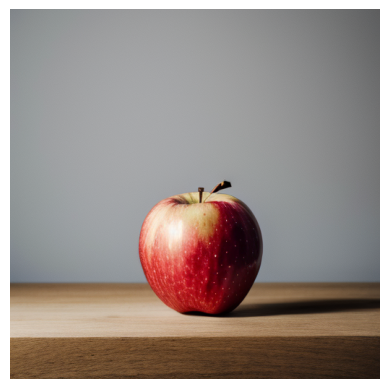

In [16]:
import cv2

image = cv2.imread(IMAGE_PATH)
show_image_from_ndarray(image)

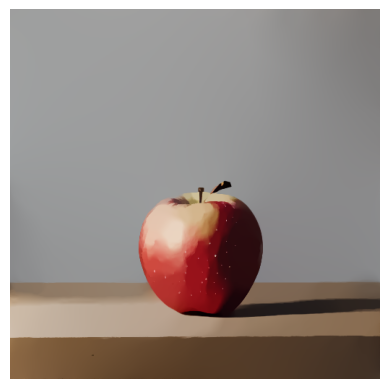

In [17]:
image_smooth = L0_smooth(image, lambda_p=0.025)

cv2.imwrite(OUTPUT_PATH, image_smooth)
cv2.waitKey(10)

show_image_from_ndarray(image_smooth)